<a href="https://colab.research.google.com/github/callee2006/MachineLearning/blob/master/MLP_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Non-linear Regression using MLP

In [1]:
! pip install mglearn

    100% |████████████████████████████████| 542kB 19.1MB/s 
  Stored in directory: /root/.cache/pip/wheels/74/cf/8d/04f4932d15854a36726c6210763c7127e62de28f5c8ddfcf3b
Successfully built mglearn


In [0]:
import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import train_test_split

import mglearn


#DATA='wave'
DATA='sin_cos'

In [0]:
# generate wave data

if DATA == "wave":
    X, y = mglearn.datasets.make_wave(n_samples=60)
    mglearn.plots.plot_linear_regression_wave()

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    plt.plot(X_train, y_train, "go")
    plt.plot(X_test, y_test, "bo")

    # reshape from (N, ) ==> (N, 1)
    y_train = np.expand_dims(y_train, axis = 1)
    y_test = np.expand_dims(y_test, axis = 1)

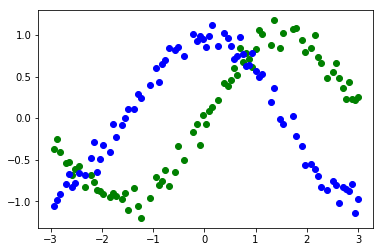

In [4]:
if DATA == 'sin_cos':
    X = np.expand_dims(np.linspace(-3, 3, 100), axis=1)
    y = np.concatenate((np.sin(X), np.cos(X)), axis = 1) + np.random.normal(0, 0.1, size = [len(X), 2])

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
    plt.plot(X_train, y_train[:, 0], "go")
    plt.plot(X_train, y_train[:, 1], "bo")

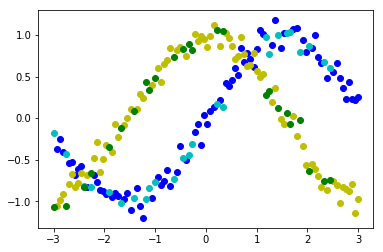

In [21]:
# convert np array into torch.Tensor

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

plt.plot(X_train[:, 0], y_train[:, 0], "bo")
plt.plot(X_test[:, 0], y_test[:, 0], "co")

if y_train.shape[1] > 1:
    plt.plot(X_train[:, 0], y_train[:, 1], "yo")
    plt.plot(X_test[:, 0], y_test[:, 1], "go")

In [6]:
print("X_train_tensor.shape = {}, y_train_tensor.shape = {}".format(X_train_tensor.shape, y_train_tensor.shape))

X_train_tensor.shape = torch.Size([75, 1]), y_train_tensor.shape = torch.Size([75, 2])


In [0]:
#design MLP regression model

class MLP_Regression(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(MLP_Regression, self).__init__()
    self.mlp = nn.Sequential(
        # 1st hidden layer
        nn.Linear(input_size, hidden_size),
        nn.ReLU(),
        
        # 2nd hidden layer
#        nn.Linear(hidden_size, hidden_size),
#        nn.ReLU(),

        
        # output layer
        nn.Linear(hidden_size, output_size),
#        nn.ReLU(),
    )
    
  def forward(self, X):
    y_ = self.mlp(X)
    return y_ 
  
model = MLP_Regression(X_train_tensor.shape[1], 50, y_train_tensor.shape[1])

In [0]:
def predict(model, input_array):
    input_tensor = torch.tensor(input_array, dtype=torch.float32).unsqueeze(dim = 1)
    predict_tensor = model(input_tensor)
#    predict = predict_tensor.squeeze().detach().numpy() 
    predict = predict_tensor.detach().numpy()     
    return predict

Train Model

In [0]:
# utility function to measure time
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [0]:
loss_fn = torch.nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
max_epoch = 10000    # maximum number of epochs
step = 0             # initialize step counter variable

start = time.time()

for epoch in range(max_epoch):
    y_hat_tensor = model(X_train_tensor)      # (N, 1)  # forward propagation
    loss = loss_fn(y_hat_tensor, y_train_tensor)  # computing loss

    if loss < 0.01:
        break
        
    optim.zero_grad()           # reset gradient
    loss.backward()             # back-propagation (compute gradient)
    optim.step()                # update parameters with gradient

    # periodically print loss
    if step % 2000 == 0:
       print("Epoch({}): {}/{}, Step: {}, Train Loss: {}".format(timeSince(start), epoch, max_epoch, step, loss.item()))

# periodically evalute model on test data
    if epoch % 50000 == 0:
        model.eval()
        with torch.no_grad():   # disable autograd
            y_hat_tensor = model(X_test_tensor)
            loss = loss_fn(y_hat_tensor, y_test_tensor)

            print('*'*20, 'Test', '*'*20)
            print('Step: {}, Test Loss: {}'.format(step, loss.item()))
            print('*' * 46)
        model.train()           # turn to train mode (enable autograd)
    step += 1

Epoch(0m 0s): 0/10000, Step: 0, Train Loss: 0.543317615986
('********************', 'Test', '********************')
Step: 0, Test Loss: 0.548737168312
**********************************************


In [0]:
y_hat = model(X_test_tensor).detach().numpy()

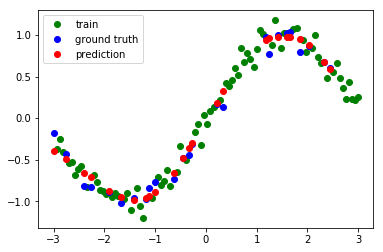

In [13]:
plt.plot(X_train[:,0], y_train[:,0], 'go', label='train')
plt.plot(X_test[:,0], y_test[:,0], 'bo', label='ground truth')
plt.plot(X_test[:,0], y_hat[:,0], 'ro', label='prediction')
plt.legend()

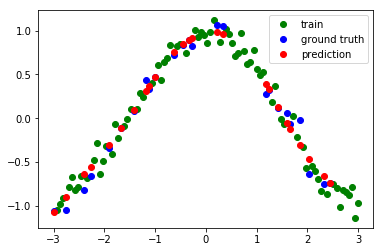

In [23]:
plt.plot(X_train[:,0], y_train[:,1], 'go', label='train')
plt.plot(X_test[:,0], y_test[:,1], 'bo', label='ground truth')
plt.plot(X_test[:,0], y_hat[:,1], 'ro', label='prediction')
plt.legend()

In [26]:
mse = ((y_hat - y_test)**2).mean()
print("mean squared error = {:0.3f}".format(mse))

mean squared error = 0.010


In [0]:
# to compare the prediction with ground truth
# merged = np.concatenate((X_test, y_test, y_hat, y_hat - y_test), axis = 1)
# np.sort(merged, axis = 0)

In [0]:
# original code
"""
x_axis = np.linspace(-3, 3, 100)
input_tensor = torch.tensor(x_axis, dtype=torch.float32). unsqueeze(dim = 1)
print("input_tensor.shape = {}".format(input_tensor.shape))

y_predict_tensor = model(input_tensor)
y_predict = y_predict_tensor.detach().numpy()
"""

In [29]:
x_axis = np.linspace(-3, 3, 100)
y_predict = predict(model, x_axis)
y_predict.shape

(100, 2)

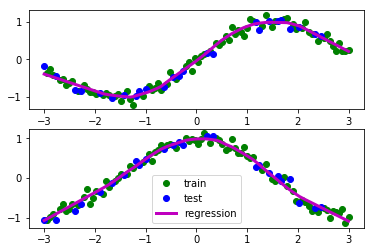

In [30]:
if y_predict.shape[1] == 1:
    plt.plot(X_train[:,0], y_train[:,0], 'go', label='train')
    plt.plot(X_test[:,0], y_test[:,0], 'bo', label='test')
    plt.plot(x_axis, y_predict[:,0], 'm', label = 'regression', linewidth=3.0)
    plt.legend()
    
elif y_predict.shape[1] == 2:
    plt.subplot(2,1,1)

    plt.plot(X_train[:,0], y_train[:,0], 'go', label='train')
    plt.plot(X_test[:,0], y_test[:,0], 'bo', label='test')

    plt.plot(x_axis, y_predict[:,0], 'm', label = 'regression', linewidth=3.0)


    plt.subplot(2,1,2)

    plt.plot(X_train[:,0], y_train[:,1], 'go', label='train')
    plt.plot(X_test[:,0], y_test[:,1], 'bo', label='test')

    plt.plot(x_axis, y_predict[:,1], 'm', label = 'regression', linewidth=3.0)

    plt.legend()